# Customer Lifetime Value (CLV) 

**Authors :**
* Louiza AOUAOUCHE
* Salim ABDOU DAOURA

**DESCRIPTION:**

The project consists in studying basic estimators so as to predict the potential duration that a customer could live in a company before churning. We define it as its lifetime value. For that, we use two type of data :
* Not censored data : means that at the moment of the measure, all the durations are known
* Censored data (more realistic): means that, for some customers, the duration is unknown since they are still in the company. (Their lifetimes will be equal to their seniority values in the company - ancienneté in french)

We use estimators based on three distributions because of their similarity with the survival function:
* **[Geometric distribution](./geometric.ipynb)**
* **[Exponential distribution](./exponential.ipynb)**
* **[Pareto distribution](./pareto.ipynb)**

Once we studied the consistency of our estimators on randomly generated data, we apply the result on real data. For that we use a dataset from the package `sksurv.datasets` called `The Veterans’ Administration Lung Cancer Trial` which is a randomized trial of two treatment regimens for lung cancer. The data set (Kalbfleisch J. and Prentice R, (1980) The Statistical Analysis of Failure Time Data. New York: Wiley) consists of 137 patients and 8 variables, which are described below:

* **Treatment**: denotes the type of lung cancer treatment; standard and test drug.
* **Celltype**: denotes the type of cell involved; squamous, small cell, adeno, large.
* **Karnofsky_score**: is the Karnofsky score.
* **Diag**: is the time since diagnosis in months.
* **Age**: is the age in years.
* **Prior_Therapy**: denotes any prior therapy; none or yes.
* <span style="color:blue">**Status**</span>: denotes the status of the patient as dead or alive; dead or alive.
* <span style="color:blue">**Survival_in_days**</span>: is the survival time in days since the treatment.
([source](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#The-Veterans%E2%80%99-Administration-Lung-Cancer-Trial))

Our interest is to study how our estimators act on this datasets. For this we only use `Survival_in_days` and `Status` features.

# Real data

In [32]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f
from sksurv.datasets import load_veterans_lung_cancer

In [3]:
# loading the dataset
data_x, data_y = load_veterans_lung_cancer()

status = data_y['Status']

Y = data_y['Survival_in_days']


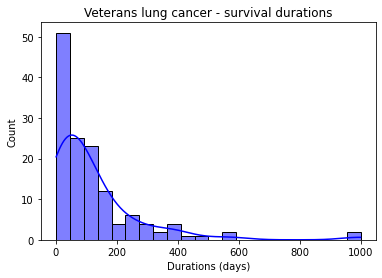

In [8]:
# plotting the distribution of durations
sns.histplot(Y, color='blue', kde=True).set(title="Veterans lung cancer - survival durations")
plt.xlabel("Durations (days)")
plt.show()


In [9]:
# computing 
clv_geom_c_r = f.geom_c_clv_estimator2(Y, status)
clv_exp_c_r = f.exp_c_clv_estimator2(Y , status)
clv_pareto_c_r = f.pareto_c_clv_estimator2(Y, status)

In [25]:
# Compare the estimators
print("Estimator Comparison:")
print("Geometric CLV Estimator:", clv_geom_c_r)
print("Exponential CLV Estimator:", clv_exp_c_r)
print("Pareto CLV Estimator:", clv_pareto_c_r)

Estimator Comparison:
Geometric CLV Estimator: 130.1796875
Exponential CLV Estimator: 130.1796875
Pareto CLV Estimator: -0.29575575369714924
